In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import ConvClassifierUs
from pclib.nn.layers import Conv2d
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity
from pclib.utils.customdataset import PreloadedDataset

In [2]:
seed = 42
# for reproducibility
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)
class PadTransform(object):
    def __call__(self, img):
        return F.pad(img, (2, 2, 2, 2), mode='constant', value=0)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
])

dataset = datasets.FashionMNIST('../Datasets/', train=True, download=True, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

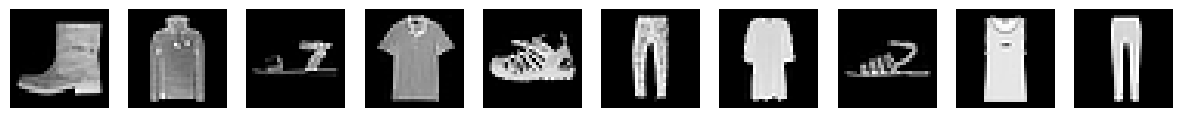

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')
Mean:  tensor(0.2187, device='cuda:0')
Std:  tensor(0.3316, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())
print('Mean: ', train_dataset.transformed_images.mean())
print('Std: ', train_dataset.transformed_images.std())

In [6]:
torch.manual_seed(seed)

model_name = 'ConvClassifierUs'
model = ConvClassifierUs(
    bias=True,
    symmetric=True, 
    actv_fn=F.tanh,
    steps=100,
    gamma=0.1,
    ).to(device)

In [8]:
# Train Loop
BATCH_SIZE = 1000

log_dir = f'examples/fashion_mnist/out/logs/{model_name}'

NUM_EPOCHS = 3
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.001,
    c_lr=0.01,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    optim='AdamW',
    log_dir=log_dir,
    scheduler='ReduceLROnPlateau',
)

# NUM_EPOCHS = 20
# train(
#     model, 
#     train_dataset, 
#     val_dataset, 
#     NUM_EPOCHS, 
#     lr=0.0,
#     c_lr=0.01,
#     batch_size=BATCH_SIZE,
#     reg_coeff=0.02,
#     flatten=False,
#     save_best=False,
#     optim='AdamW',
#     grad_mode='auto',
#     log_dir=log_dir,
#     minimal_stats=True,
#     scheduler='ReduceLROnPlateau',
# )

KeyboardInterrupt: 

In [11]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0, flatten=False)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.6145 | error_rate: 38.55 %


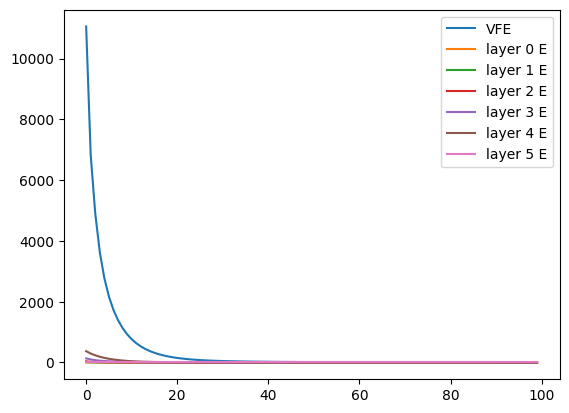

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


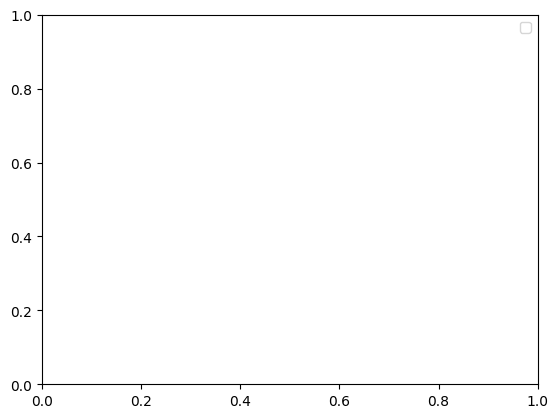

([11054.294921875,
  6829.6259765625,
  4901.408203125,
  3626.6552734375,
  2772.349365234375,
  2169.7841796875,
  1727.0966796875,
  1391.9287109375,
  1132.246337890625,
  927.8731079101562,
  765.2152709960938,
  634.7152099609375,
  529.3319702148438,
  443.7486877441406,
  373.96624755859375,
  316.8905029296875,
  269.832275390625,
  230.86314392089844,
  198.55433654785156,
  171.6207733154297,
  149.13040161132812,
  130.16220092773438,
  114.28520965576172,
  100.72616577148438,
  89.24921417236328,
  79.43795776367188,
  71.06944274902344,
  63.84781265258789,
  57.58409118652344,
  52.20451736450195,
  47.50653076171875,
  43.41851806640625,
  39.80841064453125,
  36.659507751464844,
  33.85442352294922,
  31.385229110717773,
  29.18212890625,
  27.21869659423828,
  25.463361740112305,
  23.86878204345703,
  22.432443618774414,
  21.143299102783203,
  19.97734832763672,
  18.892959594726562,
  17.91364288330078,
  17.025390625,
  16.20396614074707,
  15.448993682861328,
  

In [14]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images
y = format_y(y, 10)

track_vfe(model, x, steps=100, plot_Es=True)